In [1]:
import os
import glob
import sys
import pickle
import warnings
from datetime import datetime
from functools import reduce
from typing import List, Optional # Import types for clarity

from collections import defaultdict

from typing import Any, Dict, List, Optional, Tuple


import difflib
from html import escape

import json

import math
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.special import kl_div, softmax
from scipy.linalg import norm
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
from scipy.stats import linregress

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.contingency_tables import mcnemar
from patsy import dmatrix, Treatment
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import r2_score
from sklearn.linear_model import TheilSenRegressor

import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator
from matplotlib.patches import Circle
from matplotlib.patches import Patch
from matplotlib import font_manager as fm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from reportlab.lib.pagesizes import LETTER, landscape
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.enums import TA_LEFT
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.platypus import Table, TableStyle
from reportlab.lib import colors
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

from textwrap import wrap

from itertools import product


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Set font to Arial and size to 11
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11

In [2]:
windows_path = r"C:\Users\steph\Box\Stephen Ma's Files\Projects\0 - Data Science\R01\Prospective Labeling V3\Data\\"
mac_path = "/Users/stephenma/Library/CloudStorage/Box-Box/Stephen Ma's Files/Projects/4 - LLMs/SMI-DRC Specialty/Data//" # Define Mac path if needed

# Get the current operating system
current_os = sys.platform
print(f"Operating System: {current_os}")

# Choose the appropriate path based on the current operating system
if current_os == "win32":
    chosen_path = windows_path
    this_device = "cpu"
elif current_os == "darwin":
    chosen_path = mac_path
    this_device = "mps"
else:
    print("Unsupported operating system. Defaulting to Windows path.")
    chosen_path = windows_path
    this_device = "cpu"
    # Or handle error: sys.exit(1)

# Now, you can use the 'chosen_path' variable for further file operations
print("Chosen path:", chosen_path)

# Set data folder based on OS
dataFolder = chosen_path

# Adjust these paths to point to your Roboto Condensed font files
pdfmetrics.registerFont(TTFont("RobotoCondensed", dataFolder + "/Fonts/RobotoCondensed-Regular.ttf"))
pdfmetrics.registerFont(TTFont("RobotoCondensed-Bold", dataFolder + "/Fonts/RobotoCondensed-Bold.ttf"))

def register_roboto_condensed(font_dir: str = "static",
                              font_size: int = 11) -> fm.FontProperties:
    """
    Register Roboto Condensed Regular + Bold and set the *global* Matplotlib
    defaults to use this face at `font_size` points.

    Parameters
    ----------
    font_dir   : directory holding RobotoCondensed-Regular.ttf & …-Bold.ttf
    font_size  : base font size in points (all plot text scales from this)
    """
    reg_path  = os.path.join(font_dir, "RobotoCondensed-Regular.ttf")
    bold_path = os.path.join(font_dir, "RobotoCondensed-Bold.ttf")

    fm.fontManager.addfont(reg_path)
    fm.fontManager.addfont(bold_path)

    # Global defaults
    plt.rcParams.update({
        "font.family"  : "Roboto Condensed",
        "font.size"    : font_size,
        "axes.titlesize": font_size * 1.25,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
    })

    return fm.FontProperties(fname=reg_path)

# Call once at the start of your notebook / script
roboto_condensed_fp = register_roboto_condensed(dataFolder + "/Fonts/", font_size=12) 

Operating System: win32
Chosen path: C:\Users\steph\Box\Stephen Ma's Files\Projects\0 - Data Science\R01\Prospective Labeling V3\Data\\


## Load Data

In [3]:
# ──────────────────────────────────────────────────────────────
# Read the label files
# ──────────────────────────────────────────────────────────────
LLM_label_all   = pd.read_excel(dataFolder + "LLM Labels.xlsx")
Physician_label = pd.read_excel(dataFolder + "Stephen Labels.xlsx")

# ──────────────────────────────────────────────────────────────
# 1) Build the set of "error" indices from the PHYSICIAN sheet
# ──────────────────────────────────────────────────────────────
error_indices_set = set(
    Physician_label.loc[Physician_label["Source"] == "Error", "Index"]
)

# ──────────────────────────────────────────────────────────────
# 2) Order-preserving de-duplication of LLM indices, then drop errors
# ──────────────────────────────────────────────────────────────
ordered_unique = (
    LLM_label_all
    .drop_duplicates(subset="Index", keep="first")          # keep first appearance
    .loc[~LLM_label_all["Index"].isin(error_indices_set)]   # remove “error” indices
)

# ──────────────────────────────────────────────────────────────
# 3) Split into NaN vs non-NaN Source groups
# ──────────────────────────────────────────────────────────────
idx_nan   = ordered_unique.loc[ordered_unique["Source"].isna(),  "Index"].to_numpy()
idx_notna = ordered_unique.loc[ordered_unique["Source"].notna(), "Index"].to_numpy()

# ──────────────────────────────────────────────────────────────
# 4) Take n/2 from each camp, topping up if one camp is short
# ──────────────────────────────────────────────────────────────
n      = 100
n_half = n // 2

take_nan   = idx_nan[:n_half]
take_notna = idx_notna[:n_half]

# If either side has fewer than n_half, top-up from the other side
if len(take_nan) < n_half:
    extra = n_half - len(take_nan)
    take_notna = idx_notna[: n_half + extra]
elif len(take_notna) < n_half:
    extra = n_half - len(take_notna)
    take_nan = idx_nan[: n_half + extra]

first_n_indices = np.concatenate([take_nan, take_notna])[:n].tolist()

print(f"Final selection: {len(first_n_indices)} indices "
      f"({len(take_nan)} NaN Source, {len(take_notna)} non-NaN Source).")

# ──────────────────────────────────────────────────────────────
# 5) Filter both DataFrames
# ──────────────────────────────────────────────────────────────
LLM_label       = LLM_label_all[LLM_label_all["Index"].isin(first_n_indices)]
Physician_label = Physician_label[Physician_label["Index"].isin(first_n_indices)]


Final selection: 100 indices (50 NaN Source, 50 non-NaN Source).


In [4]:
first_n_indices

[2432,
 19667,
 21392,
 22585,
 22789,
 25822,
 27428,
 38938,
 39901,
 44402,
 46039,
 49823,
 53391,
 60920,
 63940,
 78318,
 79480,
 82643,
 94483,
 100157,
 101519,
 106367,
 106820,
 110718,
 111440,
 117036,
 124222,
 134264,
 140824,
 146126,
 149506,
 160988,
 173987,
 190304,
 208055,
 217691,
 223678,
 231119,
 239336,
 241520,
 241620,
 248166,
 265165,
 265647,
 283211,
 285732,
 290398,
 295864,
 305128,
 314021,
 5598,
 11928,
 14858,
 29023,
 30451,
 39933,
 41322,
 49714,
 55744,
 65791,
 72081,
 83153,
 85971,
 89405,
 99713,
 104179,
 108523,
 110120,
 113473,
 118469,
 120351,
 124776,
 135202,
 139937,
 140373,
 145813,
 147664,
 159295,
 160258,
 166720,
 171849,
 176142,
 180195,
 184776,
 188565,
 190057,
 197077,
 205221,
 207720,
 214001,
 231948,
 233511,
 238215,
 240196,
 248247,
 251860,
 258084,
 262055,
 279586,
 281063]

In [5]:
baseline_labels = LLM_label[LLM_label["Source"] == "Baseline"]
enhanced_labels = LLM_label[LLM_label["Source"] == "Enhanced"]
physician_labels = Physician_label[Physician_label["Source"].isin(["Baseline", "Enhanced", "Human"])]


In [6]:
# --------- Helper to join non-empty strings ---------
def _join_plus(series: pd.Series) -> str:
    """Concatenate non-blank, non-NaN strings with '+'."""
    clean_vals = [
        str(v).strip()
        for v in series.dropna().astype(str)
        if str(v).strip() != ""
    ]
    return "+".join(clean_vals)

# --------- Ensure comment fields are strings (convert NaNs to '') ---------
physician_labels["Rationale"] = physician_labels["Rationale"].fillna("").astype(str)
physician_labels["Free Text Comments"] = physician_labels["Free Text Comments"].fillna("").astype(str)

# --------- Collapse by Index & Error Code ---------
physician_labels_collapsed = (
    physician_labels
    .groupby(["Index", "Error Code"], as_index=False)
    .agg(
        Domain=("Domain", "first"),
        Subdomain=("Subdomain", "first"),
        Error_Code=("Error Code", "first"),        # redundant but keeps column order clear
        Source=("Source", _join_plus),
        Rationale=("Rationale", _join_plus),
        Free_Text_Comments=("Free Text Comments", _join_plus),
    )
)


C:\Users\steph\AppData\Local\Temp\ipykernel_23672\3183541931.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physician_labels["Rationale"] = physician_labels["Rationale"].fillna("").astype(str)
C:\Users\steph\AppData\Local\Temp\ipykernel_23672\3183541931.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physician_labels["Free Text Comments"] = physician_labels["Free Text Comments"].fillna("").astype(str)


In [7]:
physician_labels_collapsed

,Index,Error Code,Domain,Subdomain,Error_Code,Source,Rationale,Free_Text_Comments
0,2432,Violation of Standard Workflows,Clinical Reasoning,Workflow Recommendations,Violation of Standard Workflows,Human,Clinic appears to schedule directly via messag...,
1,5598,Off-topic or Irrelevant Reply to Patient Query,Clinical Reasoning,Comprehension of Patient Query,Off-topic or Irrelevant Reply to Patient Query,Baseline+Enhanced,The response is irrelevant to the patient's or...,
2,11928,Ambiguous or Conflicting Instructions,Communication Quality & Readability,Clarity,Ambiguous or Conflicting Instructions,Enhanced,The instructions are contradictory since they ...,
3,11928,Inappropriate or Omitted Diagnostic Test Recom...,Clinical Reasoning,Clinical Recommendations,Inappropriate or Omitted Diagnostic Test Recom...,Enhanced,The reply incorrectly advises a new blood draw...,
4,11928,Incorrect Clinical Information,Clinical Reasoning,Comprehension of Patient Context,Incorrect Clinical Information,Human,LLM did not realize that the CBC had already b...,
...,...,...,...,...,...,...,...,...
97,251860,Incorrect Clinical Information,Clinical Reasoning,Comprehension of Patient Context,Incorrect Clinical Information,Enhanced,The error lies in stating that genetic testing...,
98,258084,Violation of Standard Workflows,Clinical Reasoning,Workflow Recommendations,Violation of Standard Workflows,Human,The response incorrectly refers the patient to...,
99,262055,Violation of Standard Workflows,Clinical Reasoning,Workflow Recommendations,Violation of Standard Workflows,Human,"At school, the patient should be requesting no...",Something about secondary gain
100,281063,Outdated Clinical Information,Clinical Reasoning,Comprehension of Patient Context,Outdated Clinical Information,Human,The response was based on historical dosing da...,


## Basic Stats

In [20]:
"""
Fully self-contained script that generates ONE hierarchical comparison table
(Baseline vs Enhanced vs Physician) with **all counts de-duplicated by Index**,
then exports it to **both a PDF and an Excel file**.

Updates in this version
───────────────────────
• Section headers now read:
      – “Domain-Level Error Counts”
      – “Subdomain-Level Error Counts”
      – “Error-Code-Level Error Counts”

Formatting rules (unchanged except for the new header text)
───────────────────────────────────────────────────────────
  • 8-point font everywhere (adjustable via `font_size`)
  • NO blank spacer rows
  • Heavy horizontal rule only under the column-header row
  • Section headers (“Domain-Level …”, etc.) **bold**
  • Summary rows (“Cases with ≥1 error”, "Case-level error rate (%)") **bold**
  • Numeric columns right-aligned; “Category” column left-aligned
  • Row order:
        Cases with ≥1 error          (bold)
        Case-level error rate (%)               (bold)
        Domain-level error counts    (bold)
          <Domains alphabetically>
        Subdomain-level error counts (bold)
            <Domain | Subdomain alphabetically>
        Error Code-level error counts (bold)
              <Domain | Subdomain | ErrorCode alphabetically>
"""

# ─────────────────────────────────────────────────────────────────────────────
# Imports
# ─────────────────────────────────────────────────────────────────────────────
import os
from typing import Dict, List, Set, Union

import pandas as pd
from reportlab.lib import colors
from reportlab.lib.pagesizes import LETTER
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import (
    SimpleDocTemplate,
    Paragraph,
    Spacer,
    Table,
    TableStyle,
)

# ─────────────────────────────────────────────────────────────────────────────
# 1️⃣  Aggregate **unique Index** counts for each hierarchy level
# ─────────────────────────────────────────────────────────────────────────────
def _aggregate_unique_index_counts(
    datasets: Dict[str, pd.DataFrame],
    group_cols: List[str],
    first_n_indices: Union[List[int], Set[int]],
) -> pd.DataFrame:
    """
    Return a DataFrame whose rows are hierarchy labels (Domain, Domain|Subdomain,
    etc.) and whose columns are Baseline / Enhanced / Physician **unique Index
    counts**.
    """
    frames = []
    for name, df in datasets.items():
        df_r = df[df["Index"].isin(first_n_indices)]
        counts = (
            df_r.groupby(group_cols, dropna=True)["Index"]
            .nunique()
            .rename(name)
        )
        frames.append(counts)

    out = pd.concat(frames, axis=1).fillna(0).astype(int)

    # Collapse any MultiIndex into a single pipe-separated label
    def _join(idx):
        if isinstance(idx, tuple):
            return " | ".join(str(x) for x in idx if pd.notna(x))
        return str(idx)

    out.index = out.index.map(_join)
    return out.sort_index()  # alphabetical order


def build_component_tables(
    baseline_df: pd.DataFrame,
    enhanced_df: pd.DataFrame,
    physician_df: pd.DataFrame,
    first_n_indices: Union[List[int], Set[int]],
) -> Dict[str, pd.DataFrame]:
    """
    Build four DataFrames (all based on unique Index counts):

      • summary       → two rows (Cases with ≥1 error, "Case-level error rate (%)")
      • by_domain     → Domain rows
      • by_subdomain  → Domain | Subdomain rows
      • by_errorcode  → Domain | Subdomain | Error Code rows
    """
    datasets = {
        "Baseline": baseline_df,
        "Enhanced": enhanced_df,
        "Physician": physician_df,
    }
    total_cases = len(set(first_n_indices))

    # ---- Summary table ----------------------------------------------------
    summary_rows = []
    for metric in ["Cases with ≥1 error", "Case-level error rate (%)"]:
        vals = {}
        for name, df in datasets.items():
            df_r = df[df["Index"].isin(first_n_indices)]
            n_err = df_r["Index"].nunique()
            vals[name] = (
                n_err
                if metric == "Cases with ≥1 error"
                else f"{(n_err / total_cases) * 100:.1f}%"
            )
        summary_rows.append(pd.Series(vals, name=metric))

    summary_df = pd.DataFrame(summary_rows)

    # ---- Granular breakdowns ---------------------------------------------
    by_domain = _aggregate_unique_index_counts(datasets, ["Domain"], first_n_indices)
    by_subdomain = _aggregate_unique_index_counts(
        datasets, ["Domain", "Subdomain"], first_n_indices
    )
    by_errorcode = _aggregate_unique_index_counts(
        datasets, ["Domain", "Subdomain", "Error Code"], first_n_indices
    )

    return {
        "summary": summary_df,
        "by_domain": by_domain,
        "by_subdomain": by_subdomain,
        "by_errorcode": by_errorcode,
    }

# ─────────────────────────────────────────────────────────────────────────────
# 2️⃣  Build hierarchical rows (indentation, no blank rows)
# ─────────────────────────────────────────────────────────────────────────────
DOMAIN_HDR     = "Domain-level error counts"
SUBDOMAIN_HDR  = "Subdomain-level error counts"
ERRORCODE_HDR  = "Error Code-level error counts"

def make_hierarchical_rows(tables: Dict[str, pd.DataFrame]) -> list:
    indent = {"domain": "  ", "subdomain": "    ", "error": "      "}
    rows: list = []

    # Summary rows
    rows.append(
        ["Cases with ≥1 error", *tables["summary"].loc["Cases with ≥1 error"].tolist()]
    )
    rows.append(
        ["Case-level error rate (%)", *tables["summary"].loc["Case-level error rate (%)"].tolist()]
    )

    # Domain section
    rows.append([DOMAIN_HDR, "", "", ""])
    for dom, vals in tables["by_domain"].iterrows():
        rows.append([f"{indent['domain']}{dom}", *vals.tolist()])

    # Subdomain section
    rows.append([SUBDOMAIN_HDR, "", "", ""])
    for sub, vals in tables["by_subdomain"].iterrows():
        rows.append([f"{indent['subdomain']}{sub}", *vals.tolist()])

    # Error-code section
    rows.append([ERRORCODE_HDR, "", "", ""])
    for err, vals in tables["by_errorcode"].iterrows():
        rows.append([f"{indent['error']}{err}", *vals.tolist()])

    return rows

# ─────────────────────────────────────────────────────────────────────────────
# 3️⃣  ReportLab table:
#     • 8-pt font
#     • bold header row, bold section headers, bold summary rows
#     • heavy horizontal rule ONLY beneath header row
# ─────────────────────────────────────────────────────────────────────────────
def build_rl_table(rows: list, font_size: float = 7.5) -> Table:
    data = [["Category", "Baseline", "Enhanced", "Physician"]] + rows

    # rows whose *label cell* should be bold
    bold_labels = {
        DOMAIN_HDR,
        SUBDOMAIN_HDR,
        ERRORCODE_HDR,
        "Cases with ≥1 error",
        "Case-level error rate (%)",
    }
    bold_row_indices = [
        idx for idx, r in enumerate(data) if r[0] in bold_labels or idx == 0
    ]

    tbl = Table(data, hAlign="LEFT")

    style_cmds = [
        ("BOX",       (0, 0), (-1, -1), 0.5, colors.black),
        ("INNERGRID", (0, 0), (-1, -1), 0.25, colors.grey),
        ("FONTSIZE",  (0, 0), (-1, -1), font_size),
        ("FONTNAME",  (0, 0), (-1, -1), "RobotoCondensed"),     # base font
        ("ALIGN",     (1, 1), (-1, -1), "RIGHT"),
        ("ALIGN",     (0, 1), (0, -1), "LEFT"),
        ("LINEBELOW", (0, 0), (-1, 0), 1.0, colors.black),
        ("FONTNAME",  (0, 0), (0, 0), "RobotoCondensed-Bold"),  # header row label
    ]

    # Bold summary + section headers
    for row_idx in bold_row_indices[1:]:  # skip 0 (already bold)
        style_cmds.append(("FONTNAME", (0, row_idx), (0, row_idx), "RobotoCondensed-Bold"))

    tbl.setStyle(TableStyle(style_cmds))
    return tbl

# ─────────────────────────────────────────────────────────────────────────────
# 4️⃣  End-to-end driver: build tables → export single-table PDF + Excel
# ─────────────────────────────────────────────────────────────────────────────
def export_hierarchical_error_stats(
    baseline_df: pd.DataFrame,
    enhanced_df: pd.DataFrame,
    physician_df: pd.DataFrame,
    first_n_indices: Union[List[int], Set[int]],
    pdf_path: str = "error_statistics_comparison.pdf",
    excel_path: str = "error_statistics_comparison.xlsx",
    font_size: float = 7.5,   # set to 6.5 if many rows overflow
) -> None:
    """
    Generate the hierarchical comparison table and export it to both PDF
    (formatted via ReportLab) and Excel (simple tabular form).
    """
    tables = build_component_tables(
        baseline_df, enhanced_df, physician_df, first_n_indices
    )
    rows = make_hierarchical_rows(tables)

    # ---------------- PDF export ----------------
    rl_table = build_rl_table(rows, font_size=font_size)

    doc = SimpleDocTemplate(
        pdf_path,
        pagesize=LETTER,
        rightMargin=0.5 * 72,
        leftMargin=0.5 * 72,
        topMargin=0.5 * 72,
        bottomMargin=0.5 * 72,
    )

    styles = getSampleStyleSheet()
    elements = [
        Paragraph("<b>AI Error-Label Comparison</b>", styles["Title"]),
        Spacer(1, 12),
        rl_table,
    ]
    doc.build(elements)
    print(f"✅  PDF created at: {os.path.abspath(pdf_path)}")

    # ---------------- Excel export ----------------
    excel_df = pd.DataFrame(
        rows,
        columns=["Category", "Baseline", "Enhanced", "Physician"],
    )
    excel_df.to_excel(excel_path, index=False)
    print(f"✅  Excel file created at: {os.path.abspath(excel_path)}")

# ─────────────────────────────────────────────────────────────────────────────
# 5️⃣  Example invocation (assumes DataFrames already exist)
# ─────────────────────────────────────────────────────────────────────────────
export_hierarchical_error_stats(
    baseline_df  = baseline_labels,            # ← replace with your DataFrame
    enhanced_df  = enhanced_labels,            # ← replace with your DataFrame
    physician_df = physician_labels_collapsed, # ← replace with your DataFrame
    first_n_indices = first_n_indices,         # ← replace with your list / set
    pdf_path   = dataFolder + "/error_statistics_comparison.pdf",
    excel_path = dataFolder + "/error_statistics_comparison.xlsx",
    font_size  = 7.5,
)

# The resulting PDF **and** Excel file include:
#   • Bold column header row
#   • Bold summary rows (Cases with ≥1 error, Error rate %)
#   • Bold section header rows with the new titles:
#         “Domain-Level Error Counts”
#         “Subdomain-Level Error Counts”
#         “Error-Code-Level Error Counts”
# and retain all other specified formatting constraints.


✅  PDF created at: C:\Users\steph\Box\Stephen Ma's Files\Projects\0 - Data Science\R01\Prospective Labeling V3\Data\error_statistics_comparison.pdf
✅  Excel file created at: C:\Users\steph\Box\Stephen Ma's Files\Projects\0 - Data Science\R01\Prospective Labeling V3\Data\error_statistics_comparison.xlsx


## Complete Concordance Analysis

In [9]:
def concordance_by_columns(
    baseline_df: pd.DataFrame,
    enhanced_df: pd.DataFrame,
    physician_df: pd.DataFrame,
    index_list: list[int] | pd.Series,
    cols: list[str],          # e.g. ["Domain","Subdomain"]  or  ["Error Code"]
    label: str                # e.g. "Domain | Subdomain"
) -> pd.DataFrame:
    """
    Compare Baseline / Enhanced label sets against Physician at an arbitrary
    feature granularity.  Returns a DataFrame that now includes:

        • <source>_vals      —   the raw Python set for each Index
        • <source> <label>   —   "; "-joined string (unchanged, for easy reading)
        • <source> ≡ Physician (<label>) — boolean concordance flag
    """
    # ----------------- Helper: label set for one Index ------------------ #
    def _values(df, idx):
        vals = df.loc[df["Index"] == idx, cols].dropna().values
        return set(map(tuple, vals)) if vals.size else set()

    rows = []
    for idx in index_list:
        b_set = _values(baseline_df,  idx)
        e_set = _values(enhanced_df,  idx)
        p_set = _values(physician_df, idx)

        rows.append({
            "Index": idx,
            # raw sets ----------------------------------------------------
            f"Baseline {label}":  b_set,
            f"Physician {label}": p_set,
            f"Enhanced {label}":  e_set,
            # concordance flags ------------------------------------------
            f"Baseline ≡ Physician ({label})":  b_set == p_set,
            f"Enhanced ≡ Physician ({label})":  e_set == p_set,
        })

    out = pd.DataFrame(rows)

    # ------------- Console summary (unchanged) -------------------------- #
    n    = len(index_list)
    b_ok = out[f"Baseline ≡ Physician ({label})"].sum()
    e_ok = out[f"Enhanced ≡ Physician ({label})"].sum()
    print(f"===== Concordance at {label} =====")
    print(f"Baseline vs Physician : {b_ok}/{n} ({b_ok/n:.1%})")
    print(f"Enhanced vs Physician : {e_ok}/{n} ({e_ok/n:.1%})\n")

    return out

def evaluate_concordance_and_significance(concord_df: pd.DataFrame, label: str) -> dict:
    baseline_col = f"Baseline ≡ Physician ({label})"
    enhanced_col = f"Enhanced ≡ Physician ({label})"

    n = len(concord_df)
    baseline_matches = concord_df[baseline_col].sum()
    enhanced_matches = concord_df[enhanced_col].sum()

    baseline_rate = baseline_matches / n
    enhanced_rate = enhanced_matches / n

    # McNemar contingency table
    both_correct = ((concord_df[baseline_col]) & (concord_df[enhanced_col])).sum()
    baseline_only = ((concord_df[baseline_col]) & (~concord_df[enhanced_col])).sum()
    enhanced_only = ((~concord_df[baseline_col]) & (concord_df[enhanced_col])).sum()
    both_incorrect = ((~concord_df[baseline_col]) & (~concord_df[enhanced_col])).sum()

    table = [[both_correct, baseline_only],
             [enhanced_only, both_incorrect]]

    result = mcnemar(table, exact=False, correction=True)

    return {
        "Level": label,
        "Baseline Concordance": f"{baseline_matches} ({baseline_rate:.1%})",
        "Enhanced Concordance": f"{enhanced_matches} ({enhanced_rate:.1%})",
        "P-value": f"{result.pvalue:.4f}"
    }


# Prepare label-level data
base_dom = baseline_labels[["Index", "Domain"]].dropna().drop_duplicates()
enh_dom = enhanced_labels[["Index", "Domain"]].dropna().drop_duplicates()
phys_dom = physician_labels_collapsed[["Index", "Domain"]].dropna().drop_duplicates()

base_sub = baseline_labels[["Index", "Domain", "Subdomain"]].dropna().drop_duplicates()
enh_sub = enhanced_labels[["Index", "Domain", "Subdomain"]].dropna().drop_duplicates()
phys_sub = physician_labels_collapsed[["Index", "Domain", "Subdomain"]].dropna().drop_duplicates()

base_err = baseline_labels[["Index", "Error Code"]].dropna().drop_duplicates()
enh_err = enhanced_labels[["Index", "Error Code"]].dropna().drop_duplicates()
phys_err = physician_labels_collapsed[["Index", "Error Code"]].dropna().drop_duplicates()

first_n = list(first_n_indices)

# Get concordance frames
concord_dom = concordance_by_columns(base_dom, enh_dom, phys_dom, first_n, ["Domain"], "Domains")
concord_sub = concordance_by_columns(base_sub, enh_sub, phys_sub, first_n, ["Domain", "Subdomain"], "Domain–Subdomain pairs")
concord_err = concordance_by_columns(base_err, enh_err, phys_err, first_n, ["Error Code"], "Error Codes")

# Collect formatted results
summary = pd.DataFrame([
    evaluate_concordance_and_significance(concord_dom, "Domains"),
    evaluate_concordance_and_significance(concord_sub, "Domain–Subdomain pairs"),
    evaluate_concordance_and_significance(concord_err, "Error Codes")
])

# Write to Excel
summary.to_excel(dataFolder + "concordance_summary.xlsx", index=False)

print("Excel file saved as 'concordance_summary.xlsx'")
summary

===== Concordance at Domains =====
Baseline vs Physician : 45/100 (45.0%)
Enhanced vs Physician : 56/100 (56.0%)

===== Concordance at Domain–Subdomain pairs =====
Baseline vs Physician : 35/100 (35.0%)
Enhanced vs Physician : 50/100 (50.0%)

===== Concordance at Error Codes =====
Baseline vs Physician : 33/100 (33.0%)
Enhanced vs Physician : 50/100 (50.0%)

Excel file saved as 'concordance_summary.xlsx'


,Level,Baseline Concordance,Enhanced Concordance,P-value
0,Domains,45 (45.0%),56 (56.0%),0.0371
1,Domain–Subdomain pairs,35 (35.0%),50 (50.0%),0.0007
2,Error Codes,33 (33.0%),50 (50.0%),0.0002


In [10]:
# OPTION A ───────── using the raw-set columns (if you kept them)
mask = concord_dom["Baseline Domains"].astype(bool) | concord_dom["Enhanced Domains"].astype(bool)
count_indices = mask.sum()
print("Indices with ≥1 domain in Baseline or Enhanced:", count_indices)

Indices with ≥1 domain in Baseline or Enhanced: 50


In [11]:
concord_dom

,Index,Baseline Domains,Physician Domains,Enhanced Domains,Baseline ≡ Physician (Domains),Enhanced ≡ Physician (Domains)
0,2432,{},"{(Clinical Reasoning,)}",{},False,False
1,19667,{},"{(Clinical Reasoning,)}",{},False,False
2,21392,{},{},{},True,True
3,22585,{},{},{},True,True
4,22789,{},"{(Clinical Reasoning,)}",{},False,False
...,...,...,...,...,...,...
95,251860,"{(Clinical Reasoning,), (Communication Quality...","{(Clinical Reasoning,)}","{(Privacy & Security,), (Clinical Reasoning,),...",False,False
96,258084,"{(Clinical Reasoning,)}","{(Clinical Reasoning,)}","{(Clinical Reasoning,), (Communication Quality...",True,False
97,262055,"{(Communication Quality & Readability,), (Clin...","{(Clinical Reasoning,)}","{(Clinical Reasoning,)}",False,True
98,279586,"{(Clinical Reasoning,), (Communication Quality...",{},"{(Clinical Reasoning,), (Communication Quality...",False,False


## Concordance for Individual Labels

In [12]:
def concordance_per_feature(
    baseline_df: pd.DataFrame,
    enhanced_df: pd.DataFrame,
    physician_df: pd.DataFrame,
    index_list: list[int] | pd.Series,
    cols: list[str],            # e.g. ["Domain"]  or  ["Domain", "Subdomain"]
    label_name: str             # column header / print label
) -> pd.DataFrame:
    """
    For each unique FEATURE (defined by `cols`) compute how often Baseline
    and Enhanced *agree* with Physician on presence/absence across indices.
    """
    # -------- Helper to build: feature_key -> set(indices) ---------
    def _build_map(df):
        if isinstance(cols, str):
            cols_use = [cols]
        else:
            cols_use = cols

        uniq = df[["Index", *cols_use]].dropna().drop_duplicates()

        # build readable key (single col stays as string, multi-col joined with ' | ')
        if len(cols_use) == 1:
            keys = uniq[cols_use[0]].astype(str)
        else:
            keys = uniq[cols_use].astype(str).agg(" | ".join, axis=1)

        mapping = {}
        for idx, feat in zip(uniq["Index"], keys):
            mapping.setdefault(feat, set()).add(idx)
        return mapping

    map_base  = _build_map(baseline_df)
    map_enh   = _build_map(enhanced_df)
    map_phys  = _build_map(physician_df)

    all_feats = sorted(set(map_base) | set(map_enh) | set(map_phys))
    n_cases   = len(index_list)
    rows      = []

    # -------- Per-feature concordance counts ---------
    for feat in all_feats:
        b_set = map_base.get(feat, set())
        e_set = map_enh.get(feat,  set())
        p_set = map_phys.get(feat, set())

        base_matches = sum((idx in b_set) == (idx in p_set) for idx in index_list)
        enh_matches  = sum((idx in e_set) == (idx in p_set) for idx in index_list)

        rows.append({
            label_name:                 feat,
            "Baseline_concordant_cases":  base_matches,
            "Baseline_concordance_rate":  base_matches / n_cases,
            "Enhanced_concordant_cases":  enh_matches,
            "Enhanced_concordance_rate":  enh_matches / n_cases,
        })

    result = pd.DataFrame(rows)

    # -------- Optional: nice print summary ---------
    print(f"\n===== Concordance by {label_name} =====")
    for _, r in result.iterrows():
        print(f"{r[label_name]}:")
        print(f"  Baseline  {r['Baseline_concordant_cases']}/{n_cases} "
              f"({r['Baseline_concordance_rate']:.1%})")
        print(f"  Enhanced  {r['Enhanced_concordant_cases']}/{n_cases} "
              f"({r['Enhanced_concordance_rate']:.1%})\n")

    return result


In [13]:
# Domain level
base_dom  = baseline_labels [["Index", "Domain"]].dropna().drop_duplicates()
enh_dom   = enhanced_labels [["Index", "Domain"]].dropna().drop_duplicates()
phys_dom  = physician_labels_collapsed [["Index", "Domain"]].dropna().drop_duplicates()

# Domain + Subdomain level
base_sub  = baseline_labels [["Index", "Domain", "Subdomain"]].dropna().drop_duplicates()
enh_sub   = enhanced_labels [["Index", "Domain", "Subdomain"]].dropna().drop_duplicates()
phys_sub  = physician_labels_collapsed [["Index", "Domain", "Subdomain"]].dropna().drop_duplicates()

# Error-code level
base_err  = baseline_labels [["Index", "Domain", "Subdomain", "Error Code"]].dropna().drop_duplicates()
enh_err   = enhanced_labels [["Index", "Domain", "Subdomain", "Error Code"]].dropna().drop_duplicates()
phys_err  = physician_labels_collapsed [["Index", "Domain", "Subdomain", "Error Code"]].dropna().drop_duplicates()


first_n = list(first_n_indices)

# a) Domains
domain_concord_df = concordance_per_feature(
    baseline_df = base_dom,
    enhanced_df = enh_dom,
    physician_df = phys_dom,
    index_list  = first_n,
    cols        = ["Domain"],
    label_name  = "Domain"
)

# b) Domain–Subdomain pairs
subdomain_concord_df = concordance_per_feature(
    baseline_df = base_sub,
    enhanced_df = enh_sub,
    physician_df = phys_sub,
    index_list  = first_n,
    cols        = ["Domain", "Subdomain"],
    label_name  = "Domain | Subdomain"
)

# c) Error Codes
error_concord_df = concordance_per_feature(
    baseline_df = base_err,
    enhanced_df = enh_err,
    physician_df = phys_err,
    index_list  = first_n,
    cols        = ["Domain", "Subdomain", "Error Code"],
    label_name  = "Domain | Subdomain | Error Code"
)



===== Concordance by Domain =====
Accessibility:
  Baseline  100/100 (100.0%)
  Enhanced  99/100 (99.0%)

Bias & Stigmatization:
  Baseline  95/100 (95.0%)
  Enhanced  98/100 (98.0%)

Clinical Reasoning:
  Baseline  63/100 (63.0%)
  Enhanced  70/100 (70.0%)

Communication Quality & Readability:
  Baseline  67/100 (67.0%)
  Enhanced  82/100 (82.0%)

Privacy & Security:
  Baseline  96/100 (96.0%)
  Enhanced  93/100 (93.0%)


===== Concordance by Domain | Subdomain =====
Accessibility | Language Accommodation:
  Baseline  100/100 (100.0%)
  Enhanced  99/100 (99.0%)

Bias & Stigmatization | Identity & Respect:
  Baseline  95/100 (95.0%)
  Enhanced  98/100 (98.0%)

Clinical Reasoning | Assessment:
  Baseline  92/100 (92.0%)
  Enhanced  97/100 (97.0%)

Clinical Reasoning | Clinical Recommendations:
  Baseline  76/100 (76.0%)
  Enhanced  90/100 (90.0%)

Clinical Reasoning | Comprehension of Medical Guidelines and Standard of Care:
  Baseline  95/100 (95.0%)
  Enhanced  97/100 (97.0%)

Clinic

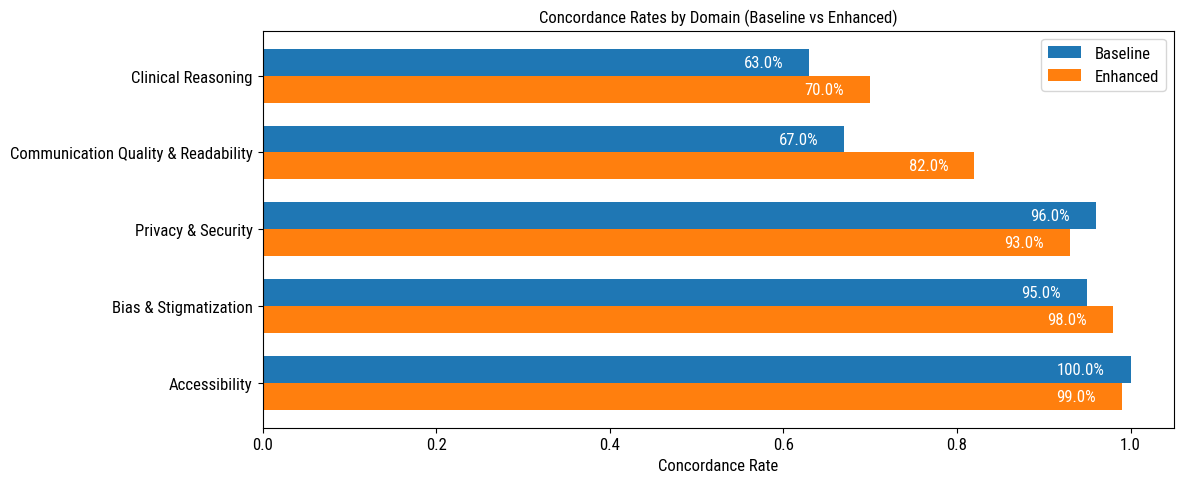

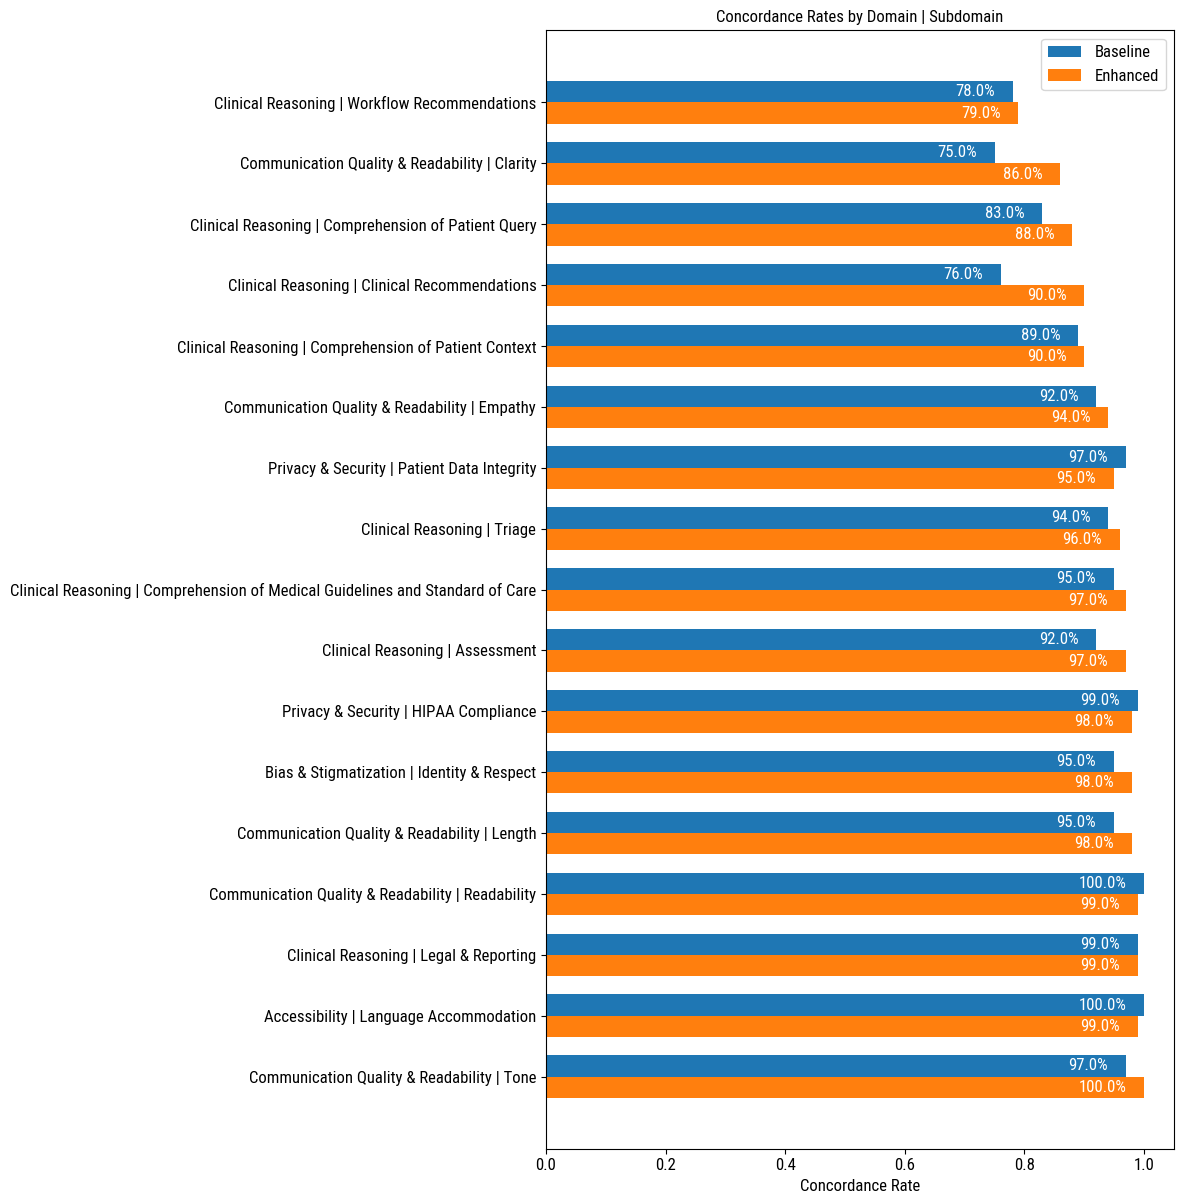

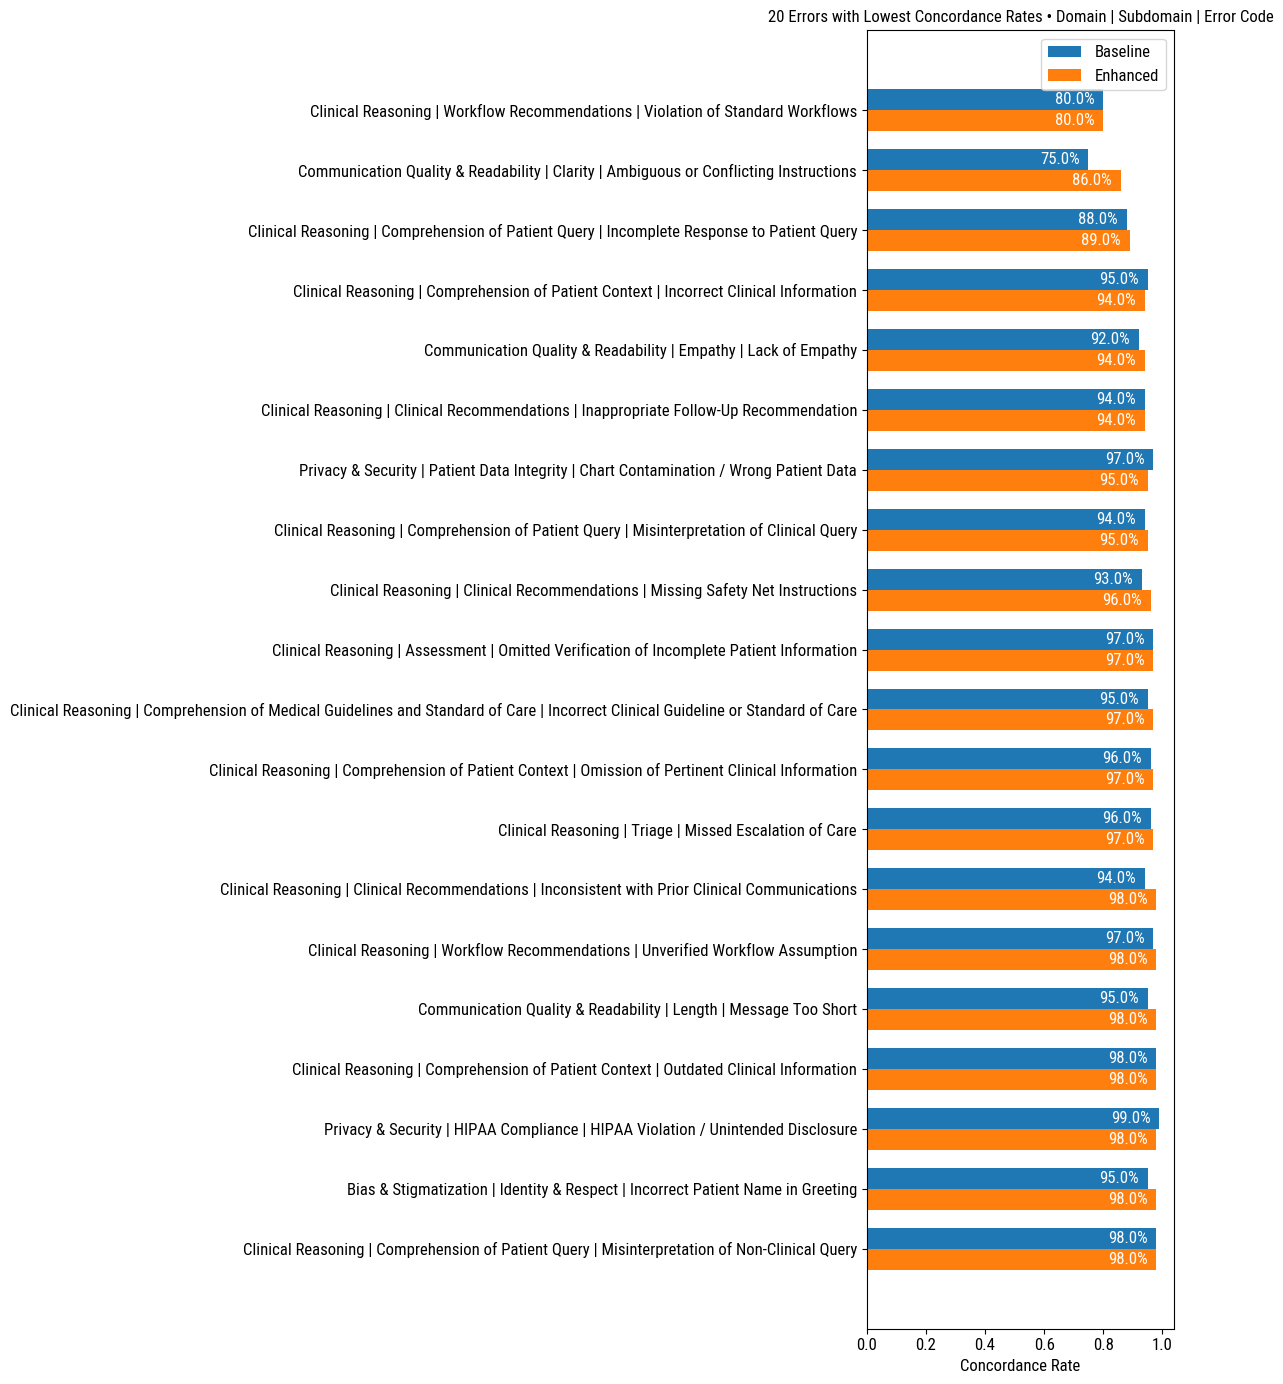

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# Concordance-rate bar-chart utility (Roboto Condensed everywhere)
# ─────────────────────────────────────────────────────────────────────────────
def plot_concordance_rates(
    concord_df: pd.DataFrame,
    feature_col: str,
    title: str,
    sort_by: str = "Baseline_concordance_rate",   # column to sort on
    top_n: int | None = None,                     # how many LOWEST to keep
    show_rates: bool = True,
    right_pad: float = 0.05,                      # x-axis breathing room
    font_prop: fm.FontProperties | None = None    # optional override
) -> None:
    """
    Horizontal bar chart of Baseline vs Enhanced concordance rates,
    showing the LOWEST-concordance features first (ascending order).

    All text elements (title, axis labels, tick labels, legend, rate
    annotations) use Roboto Condensed (or `font_prop`, if provided).
    """
    # ──────────────────────────────────────────────────────────────────
    # 1️⃣  Subset + sort
    # ──────────────────────────────────────────────────────────────────
    plot_df = concord_df[
        [feature_col, "Baseline_concordance_rate", "Enhanced_concordance_rate"]
    ].copy()
    plot_df = plot_df.sort_values(sort_by, ascending=True)
    if top_n is not None:
        plot_df = plot_df.head(top_n)

    # ──────────────────────────────────────────────────────────────────
    # 2️⃣  Figure + bars
    # ──────────────────────────────────────────────────────────────────
    y_pos  = np.arange(len(plot_df))
    height = 0.35

    fig, ax = plt.subplots(figsize=(12, 0.6 * len(plot_df) + 2))

    bars_baseline = ax.barh(
        y_pos - height / 2,
        plot_df["Baseline_concordance_rate"],
        height=height,
        label="Baseline",
        color="#1f77b4",
    )
    bars_enhanced = ax.barh(
        y_pos + height / 2,
        plot_df["Enhanced_concordance_rate"],
        height=height,
        label="Enhanced",
        color="#ff7f0e",
    )

    # ──────────────────────────────────────────────────────────────────
    # 3️⃣  Axis + legend styling
    # ──────────────────────────────────────────────────────────────────
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df[feature_col], fontproperties=font_prop or roboto_condensed_fp)
    ax.invert_yaxis()  # worst (lowest) at the top

    ax.set_xlabel("Concordance Rate", fontproperties=font_prop or roboto_condensed_fp)
    ax.set_title(title, fontproperties=font_prop or roboto_condensed_fp)
    ax.legend(loc="best", prop=font_prop or roboto_condensed_fp)

    # ──────────────────────────────────────────────────────────────────
    # 4️⃣  Numeric rate labels inside / outside bars
    # ──────────────────────────────────────────────────────────────────
    if show_rates:
        label_margin = 0.03   # 3 % of full scale
        max_rate     = plot_df[["Baseline_concordance_rate",
                                "Enhanced_concordance_rate"]].to_numpy().max()

        for bars in (bars_baseline, bars_enhanced):
            for bar in bars:
                width = bar.get_width()
                y     = bar.get_y() + bar.get_height() / 2
                label = f"{width:.1%}"

                # Decide if the label fits inside; else place just outside
                if width > label_margin:
                    x     = width - label_margin
                    ha    = "right"
                    color = "white"   # good contrast inside bar
                else:
                    x     = width + 0.002
                    ha    = "left"
                    color = "black"

                ax.text(
                    x, y, label,
                    va="center", ha=ha, color=color,
                    fontproperties=font_prop or roboto_condensed_fp
                )

    # ──────────────────────────────────────────────────────────────────
    # 5️⃣  X-axis padding so outside labels aren’t clipped
    # ──────────────────────────────────────────────────────────────────
    ax.set_xlim(0, max_rate * (1 + right_pad))

    plt.tight_layout()
    plt.show()


# Plot Domains
plot_concordance_rates(
    concord_df = domain_concord_df,
    feature_col = "Domain",
    title = "Concordance Rates by Domain (Baseline vs Enhanced)",
    sort_by = "Enhanced_concordance_rate",
    top_n = None,
)

# Plot Domain–Subdomain pairs
plot_concordance_rates(
    concord_df = subdomain_concord_df,
    feature_col = "Domain | Subdomain",
    title = "Concordance Rates by Domain | Subdomain",
    sort_by = "Enhanced_concordance_rate",
    top_n = None,
)

# Worst 20 Domain | Subdomain | Error Code triples
plot_concordance_rates(
    concord_df = error_concord_df,
    feature_col = "Domain | Subdomain | Error Code",
    title = "20 Errors with Lowest Concordance Rates • Domain | Subdomain | Error Code",
    sort_by = "Enhanced_concordance_rate",
    top_n = 20,
)


In [15]:
# ────────────────────────────────────────────────────────────────────────────
# Presence matrix *unique per Index*  (Domain, Subdomain, or Error-Code level)
# ────────────────────────────────────────────────────────────────────────────
def _presence_matrix(
    df: pd.DataFrame,
    index_pool: Set[int],
    group_cols: List[str],
) -> pd.DataFrame:
    """
    Binary matrix:
        rows  = Index in index_pool
        cols  = hierarchical labels
        cell  = 1  ⇢  label occurs ≥1× for that Index
                0  ⇢  label absent for that Index
    Guarantees **one vote per Index** for any given label.
    """
    if not group_cols:                        # case‐level shortcut
        return (
            pd.Series(1, index=df["Index"].drop_duplicates())      # unique Indexes only
              .reindex(index_pool, fill_value=0)
              .to_frame("has_error")
              .astype(int)
        )

    # de-duplicate so an Index contributes at most one row per label combo
    df_r = (
        df[df["Index"].isin(index_pool)]
          .dropna(subset=group_cols)
          .drop_duplicates(subset=["Index"] + group_cols)
          .copy()
    )
    df_r["label"] = df_r[group_cols].agg(" | ".join, axis=1)

    one_hot = (
        pd.crosstab(df_r["Index"], df_r["label"])          # each cell is 1 by construction
          .reindex(index_pool, fill_value=0)
          .astype(int)
    )
    return one_hot

# ════════════════════════════════════════════════════════════════════════
# 2️⃣  Aggregate confusion metrics across *all* labels in a matrix
# ════════════════════════════════════════════════════════════════════════
def _aggregated_confusion(pred_mat: pd.DataFrame, truth_mat: pd.DataFrame) -> Dict[str, Any]:
    """
    Treat every (index, label) pair as an independent binary decision and
    compute TP/FP/FN/TN totals + derived metrics.
    """
    all_cols = sorted(set(pred_mat.columns) | set(truth_mat.columns))
    pred  = pred_mat.reindex(columns=all_cols, fill_value=0).values.ravel()
    truth = truth_mat.reindex(columns=all_cols, fill_value=0).values.ravel()

    TP = int(((pred == 1) & (truth == 1)).sum())
    FP = int(((pred == 1) & (truth == 0)).sum())
    FN = int(((pred == 0) & (truth == 1)).sum())
    TN = int(((pred == 0) & (truth == 0)).sum())

    sens = TP / (TP + FN) if (TP + FN) else float("nan")
    spec = TN / (TN + FP) if (TN + FP) else float("nan")
    ppv  = TP / (TP + FP) if (TP + FP) else float("nan")
    npv  = TN / (TN + FN) if (TN + FN) else float("nan")
    acc  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else float("nan")
    f1   = 2 * ppv * sens / (ppv + sens) if (ppv + sens) else float("nan")

    return dict(TP=TP, FP=FP, FN=FN, TN=TN,
                Sensitivity=sens, Specificity=spec,
                PPV=ppv, NPV=npv, Accuracy=acc, F1=f1)

# ════════════════════════════════════════════════════════════════════════
# 3️⃣  Convenience wrapper for Baseline & Enhanced
# ════════════════════════════════════════════════════════════════════════
def confusion_summary(
    baseline_df: pd.DataFrame,
    enhanced_df: pd.DataFrame,
    physician_df: pd.DataFrame,
    first_n_indices: List[int] | Set[int],
    group_cols: List[str],
) -> pd.DataFrame:
    """
    Return a DataFrame exactly like:

           Baseline   Enhanced
    TP     …          …
    FP     …          …
    …

    where counts/metrics are aggregated over **all (index, label)** pairs for
    the hierarchy specified by `group_cols`.

    Examples
    --------
    • Case level           → group_cols=[]
    • Domain level         → group_cols=["Domain"]
    • Subdomain level      → group_cols=["Domain","Subdomain"]
    • Error-code level     → group_cols=["Domain","Subdomain","Error Code"]
    """
    pool = set(first_n_indices)

    # build presence matrices
    base_mat = _presence_matrix(baseline_df,  pool, group_cols)
    enh_mat  = _presence_matrix(enhanced_df,   pool, group_cols)
    truth_mat= _presence_matrix(physician_df,  pool, group_cols)

    base_stats = _aggregated_confusion(base_mat, truth_mat)
    enh_stats  = _aggregated_confusion(enh_mat,  truth_mat)

    ordered_rows = [
        "TP", "FP", "FN", "TN",
        "Sensitivity", "Specificity",
        "PPV", "NPV", "Accuracy", "F1"
    ]
    df_out = pd.DataFrame({"Baseline": base_stats, "Enhanced": enh_stats}).loc[ordered_rows]
    return df_out

# ════════════════════════════════════════════════════════════════════════
# 4️⃣  Example calls for the three hierarchy levels
# ════════════════════════════════════════════════════════════════════════
domain_conf = confusion_summary(
    baseline_df  = baseline_labels[["Index","Domain"]].dropna().drop_duplicates(),
    enhanced_df  = enhanced_labels[["Index","Domain"]].dropna().drop_duplicates(),
    physician_df = physician_labels_collapsed[["Index","Domain"]].dropna().drop_duplicates(),
    first_n_indices = first_n_indices,
    group_cols = ["Domain"],
)

subdomain_conf = confusion_summary(
    baseline_df  = baseline_labels[["Index","Domain","Subdomain"]].dropna().drop_duplicates(),
    enhanced_df  = enhanced_labels[["Index","Domain","Subdomain"]].dropna().drop_duplicates(),
    physician_df = physician_labels_collapsed[["Index","Domain","Subdomain"]].dropna().drop_duplicates(),
    first_n_indices = first_n_indices,
    group_cols = ["Domain", "Subdomain"],
)

errorcode_conf = confusion_summary(
    baseline_df  = baseline_labels[["Index","Domain","Subdomain","Error Code"]].dropna().drop_duplicates(),
    enhanced_df  = enhanced_labels[["Index","Domain","Subdomain","Error Code"]].dropna().drop_duplicates(),
    physician_df = physician_labels_collapsed[["Index","Domain","Subdomain","Error Code"]].dropna().drop_duplicates(),
    first_n_indices = first_n_indices,
    group_cols = ["Domain", "Subdomain", "Error Code"],
)

print("Domain-level confusion matrix:\n", domain_conf, "\n")
print("Subdomain-level confusion matrix:\n", subdomain_conf, "\n")
print("Error-code-level confusion matrix:\n", errorcode_conf)

# Combine all three confusion summaries side-by-side
combined = pd.concat(
    {
        "Domain Level": domain_conf,
        "Subdomain Level": subdomain_conf,
        "Error Code Level": errorcode_conf
    },
    axis=1
)

# Round all numeric values to 3 decimal places
combined = combined.round(3)

# Write to Excel
output_path = dataFolder + "confusion_summary_all_levels.xlsx"
combined.to_excel(output_path)

print(f"\nSaved confusion summaries to '{output_path}'")



Domain-level confusion matrix:
                Baseline    Enhanced
TP            42.000000   47.000000
FP            48.000000   32.000000
FN            31.000000   26.000000
TN           379.000000  395.000000
Sensitivity    0.575342    0.643836
Specificity    0.887588    0.925059
PPV            0.466667    0.594937
NPV            0.924390    0.938242
Accuracy       0.842000    0.884000
F1             0.515337    0.618421 

Subdomain-level confusion matrix:
                 Baseline     Enhanced
TP             36.000000    55.000000
FP             86.000000    58.000000
FN             58.000000    39.000000
TN           1420.000000  1448.000000
Sensitivity     0.382979     0.585106
Specificity     0.942895     0.961487
PPV             0.295082     0.486726
NPV             0.960758     0.973773
Accuracy        0.910000     0.939375
F1              0.333333     0.531401 

Error-code-level confusion matrix:
                 Baseline     Enhanced
TP             30.000000    59.000000
FP 